# Trabalho 3
Descrição do trabalho:

http://webserver2.tecgraf.puc-rio.br/~mgattass/visao/trb/T3.html

Aluno: Daniel da Silva Costa

E-mail: danieldasilvacosta@gmail.com

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
from keras.datasets import mnist
from keras.utils import np_utils
from sklearn import metrics
import pandas as pd

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

### Using PyTorch

Based on https://www.youtube.com/watch?v=oPhxf2fXHkQ&list=PLqnslRFeH2UrcDBWF5mfPGpqQDSta6VK4&index=13

#### Device configuration

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#### Hyper-parameters 

In [3]:
input_size = 784 # 28x28
hidden_size = 500 
num_classes = 10
num_epochs = 5
batch_size = 256
learning_rate = 0.001

#### MNIST dataset 

In [4]:
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

#### Data loader

Creating the batches of the training set and test set.

In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [6]:
train_loader

In [7]:
# list(enumerate(train_loader))[0]

#### Depicting examples

From test set

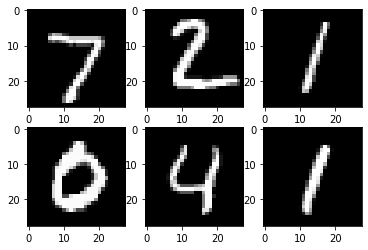

In [8]:
examples = iter(test_loader)
example_data, example_targets = examples.next()

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()

#### Neural Network

In [9]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        # no activation and no softmax at the end
        return out

In [10]:
model = NeuralNet(input_size, hidden_size, num_classes).to(device)

#### Loss and optimizer

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

#### Training

In [12]:
%%time

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # origin shape: [100, 1, 28, 28]
        # resized: [100, 784]
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [1/5], Step [100/235], Loss: 0.2909
Epoch [1/5], Step [200/235], Loss: 0.1642
Epoch [2/5], Step [100/235], Loss: 0.2086
Epoch [2/5], Step [200/235], Loss: 0.0793
Epoch [3/5], Step [100/235], Loss: 0.0944
Epoch [3/5], Step [200/235], Loss: 0.1501
Epoch [4/5], Step [100/235], Loss: 0.0565
Epoch [4/5], Step [200/235], Loss: 0.0591
Epoch [5/5], Step [100/235], Loss: 0.0384
Epoch [5/5], Step [200/235], Loss: 0.0488
CPU times: user 29 s, sys: 298 ms, total: 29.3 s
Wall time: 33.2 s


#### Testing

In [13]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the {n_samples} test images: {acc} %')

Accuracy of the network on the 10000 test images: 97.72 %


### Using the Numpy

Based on https://www.youtube.com/watch?v=M0jlQzHo5Jg

#### Utility functions

In [14]:
def to_categorical(x, n_col=None):
  """ One hot encoding function"""
  if not n_col:
    n_col = np.amax(x) + 1
  
  one_hot = np.zeros((x.shape[0], n_col))
  one_hot[np.arange(x.shape[0]), x] = 1
  return one_hot

In [15]:
def accuracy(y_true, y_pred):
  ### Returns accuracy ###
  return np.sum(y_true == y_pred, axis = 0) / len(y_true)

In [16]:
def batch_loader(X, y = None, batch_size=64):
  """ Generates batches for training"""
  n_samples = X.shape[0]
  for i in np.arange(0, n_samples, batch_size):
    begin, end = i, min(i + batch_size, n_samples)
    if y is not None:
      yield X[begin:end], y[begin: end]
    else:
      yield X[begin:end]

#### Loss

In [17]:
class CrossEntropy():
  def __init__(self): pass

  def loss(self, y, p):
    p = np.clip(p, 1e-15, 1- 1e-15)
    return -y*np.log(p) - (1 - y) * np.log(1- p)
  
  def gradient(self, y, p):
    p = np.clip(p, 1e-15, 1- 1e-15)
    return -(y/p) + (1 - y) / (1 - p)

#### Activation Functions

In [18]:
class LeakyReLU():
  def __init__(self, alpha = 0.2):
    self.alpha = alpha
  
  def __call__(self, x):
    return self.activation(x)
  
  def activation(self, x):
    return np.where(x >= 0, x, self.alpha * x)
  
  def gradient(self, x):
    return np.where(x >= 0, 1, self.alpha)

In [19]:
class Softmax():
  def __init__(self): pass
  
  def __call__(self, x):
    return self.activation(x)
  
  def activation(self, x):
    e_x = np.exp(x - np.max(x, axis = -1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims = True)
  
  def gradient(self, x):
    # Error was in our softmax
    p = self.activation(x)
    return p * (1 - p)

#### Layers

##### class Linear

Fully Connected Layer

In [20]:
class Linear():
  def __init__(self, n_in, n_out, name="linear"):
    limit = 1 / np.sqrt(n_in)
    self.W = np.random.uniform(-limit, limit, (n_in, n_out))
    self.b = np.zeros((1, n_out)) # Biases
    self.input = None
    self.output = None
    self.name = name
  
  def forward(self, x):
    self.input = x
    self.output = np.dot(self.input, self.W) + self.b # Wx + b
    return self.output
  
  def backward(self, output_gradient, learning_rate = 0.01):
    input_gradient = np.dot(output_gradient, self.W.T)
    weights_gradients = np.dot(self.input.T, output_gradient) # Calculate the weights error
    bias_gradients = np.sum(output_gradient, axis=0).reshape((1, -1))

    # Usually, we would allow an optimizer function to update the weights
    # but here, we just use simple SGD
    self.W -= learning_rate * weights_gradients
    self.b -= learning_rate * bias_gradients
    # We updated the weights below
    return input_gradient
  
  def __call__(self, x):
    return self.forward(x)

##### class Activation

In [21]:
class Activation():
  def __init__(self, activation, name="activation"):
    self.activation = activation
    self.gradient = activation.gradient
    self.input = None
    self.output = None
    self.name = name
  
  def forward(self, x):
    self.input = x
    self.output = self.activation(x)
    return self.output
  
  def backward(self, output_error, learning_rate = 0.01):
    return self.gradient(self.input) * output_error
  
  def __call__(self, x):
    return self.forward(x)

#### Network

In [22]:
class Network():
  def __init__(self, input_dim, output_dim, learning_rate=0.01):
    # input_dim = 784, output_dim = 10 for mnist
    self.layers = [
                   Linear(input_dim, 256, name="input"),
                   Activation(LeakyReLU(), name="relu1"),
                   Linear(256, 128, name="input"),
                   Activation(LeakyReLU(), name="relu2"),
                   Linear(128, output_dim, name="output"),
                   Activation(Softmax(), name="softmax")
    ]
    self.learning_rate = learning_rate
  
  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def backward(self, loss_grad):
    for layer in reversed(self.layers):
      loss_grad = layer.backward(loss_grad, self.learning_rate)
    # Iterating backwards through the layers
  
  def __call__(self, x):
    return self.forward(x)

#### Loading the data

In [23]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

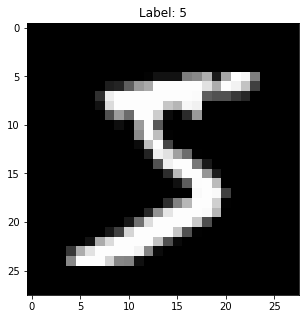

In [24]:
fig, axes = plt.subplots( 1, 1, figsize=( 10, 5 ) )

axes.set_title( f'Label: {y_train[0]}' )
axes.imshow( X_train[0], cmap='gray' )

plt.show()

In [25]:
# X_train[0]

#### Depicting examples

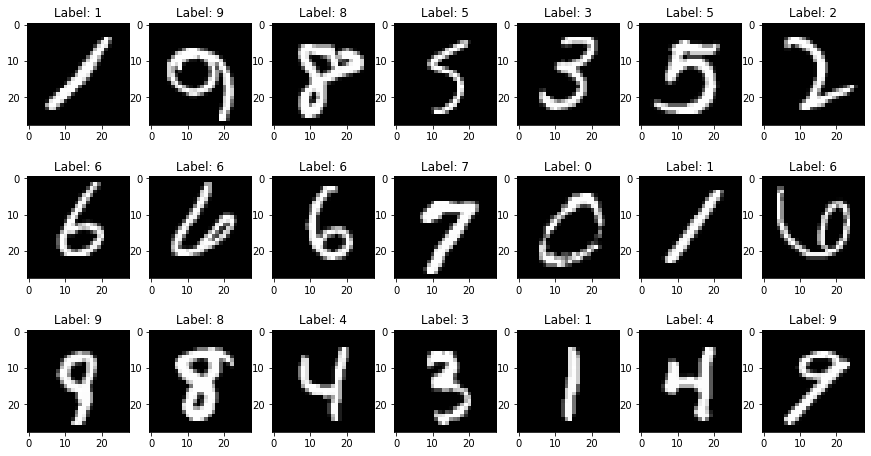

In [26]:
rows = 3
columns = 7

fig, axes = plt.subplots( rows, columns, figsize=( 15, 8 ) )

for i in range(rows):
  for j in range(columns):
    random_number = int(np.random.rand() * X_train.shape[0])
    axes[i][j].set_title( f'Label: {y_train[random_number]}' )
    axes[i][j].imshow( X_train[random_number], cmap='gray' )

plt.show()

#### Preprocessing Data

In [27]:
y_train, y_test = to_categorical(y_train.astype("int")), to_categorical(y_test.astype("int"))
X_train, X_test = X_train / 255.0, X_test / 255.0

In [28]:
X_train, X_test = X_train.reshape(-1, 28*28), X_test.reshape(-1, 28*28)
X_train.shape, X_test.shape

((60000, 784), (10000, 784))

#### Training

In [29]:
n_input_dim = 28*28 # 784
n_out = 10 # 10 classes

In [30]:
criterion = CrossEntropy()
model = Network(n_input_dim, n_out, learning_rate=1e-3)

In [31]:
EPOCHS = 5
# batch_size = 1
batch_size = 128
# batch_size = X_train.shape[0]

In [32]:
for epoch in range(EPOCHS):
  loss = []
  acc = []
  for x_batch, y_batch in batch_loader(X_train, y_train, batch_size):
    # Forward pass
    out = model(x_batch)
    
    # Loss - for display
    loss.append(np.mean(criterion.loss(y_batch, out)))
    
    # Accuracy - For display
    acc.append(accuracy(np.argmax(y_batch, axis=1), np.argmax(out, axis=1)))

    # Calculate gradient of loss
    error = criterion.gradient(y_batch, out) 
    
    # Backpropagation
    model.backward(error)
  
  print(f"Epoch {epoch + 1}, Loss: {np.mean(loss):.5}, Acc: {np.mean(acc):.3}")

Epoch 1, Loss: 0.0952, Acc: 0.843
Epoch 2, Loss: 0.043491, Acc: 0.926
Epoch 3, Loss: 0.033251, Acc: 0.944
Epoch 4, Loss: 0.026695, Acc: 0.955
Epoch 5, Loss: 0.022181, Acc: 0.964


#### Testing

##### Accuracy

In [33]:
out = model(X_test)
accuracy_value = accuracy(np.argmax(y_test, axis=1), np.argmax(out, axis=1))
print( f'{(accuracy_value * 100):.3}%' )

96.1%


##### Confusion Matrix

In [34]:
%%time

y_predicted = list(np.argmax(out, axis=1))
y_actual = list(np.argmax(y_test, axis=1))

for i, y_pred in enumerate(y_predicted):
    print('pred:', y_predicted[i], '\ttrue:', y_actual[i])

    if i > 20:
      break

pred: 7 	true: 7
pred: 2 	true: 2
pred: 1 	true: 1
pred: 0 	true: 0
pred: 4 	true: 4
pred: 1 	true: 1
pred: 4 	true: 4
pred: 9 	true: 9
pred: 6 	true: 5
pred: 9 	true: 9
pred: 0 	true: 0
pred: 6 	true: 6
pred: 9 	true: 9
pred: 0 	true: 0
pred: 1 	true: 1
pred: 5 	true: 5
pred: 9 	true: 9
pred: 7 	true: 7
pred: 3 	true: 3
pred: 4 	true: 4
pred: 9 	true: 9
pred: 6 	true: 6
CPU times: user 7.03 ms, sys: 10.7 ms, total: 17.8 ms
Wall time: 13.2 ms


In [35]:
confusion_matrix = metrics.confusion_matrix(y_actual, y_predicted)

In [36]:
# based on https://www.statology.org/confusion-matrix-python/

y_actual = pd.Series(y_actual, name='Actual')
y_predicted = pd.Series(y_predicted, name='Predicted')

#create confusion matrix
print(pd.crosstab(y_actual, y_predicted))

Predicted    0     1    2    3    4    5    6    7    8    9
Actual                                                      
0          967     0    0    2    0    5    3    1    2    0
1            0  1122    2    1    0    1    3    1    5    0
2            8     3  979   12    7    1    8    4    9    1
3            1     1    2  966    1   17    0    8    9    5
4            1     0    3    0  955    0    7    0    3   13
5            5     1    0    5    2  860    7    0    7    5
6            9     3    0    0    5   19  917    1    4    0
7            2    12   12    8    5    1    0  948    3   37
8            3     3    1    9    7    8    5    3  932    3
9            5     8    0    8   18    4    1    1    1  963


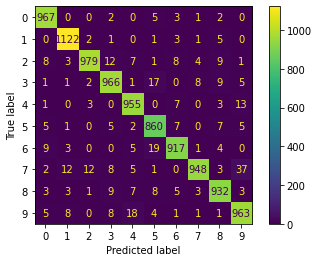

In [37]:
# based on https://www.w3schools.com/python/python_ml_confusion_matrix.asp

cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix, 
    display_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
cm_display.plot()
plt.show()

In [38]:
y_err = y_predicted[ y_predicted != y_actual ]
y_err[:20]

8      6
124    4
149    4
217    5
241    5
247    2
259    0
290    4
320    1
321    7
340    3
358    9
381    7
445    0
449    5
507    5
551    1
565    9
582    2
591    3
Name: Predicted, dtype: int64

#### Error Rate

"o valor da taxa de erro (calculada como o número de todas as previsões incorretas dividido pelo número total do conjunto de dados. A melhor taxa de erro é 0, enquanto a pior é 1.)"

In [39]:
error_rate = len(y_err) / X_train.shape[0]
print( f'error_rate: {error_rate:.3}' )

error_rate: 0.00652


In [40]:
error_rate_percentage = len(y_err) / X_train.shape[0] * 100
print( f'error_rate_percentage: {error_rate_percentage:.2}%' )

error_rate_percentage: 0.65%
